In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_decision_forests as tfdf
from matplotlib.ticker import FormatStrFormatter


import lbg_forecast.noise as noise
import lbg_forecast.colour_cuts as cuts

import optimise_stellar as stellar

from sklearn.model_selection import train_test_split


In [2]:
def build_redshift_distribution_samples_object(u_data, g_data, r_data):

    u_redshifts = cuts.get_zs(u_data)
    g_redshifts = cuts.get_zs(g_data)
    r_redshifts = cuts.get_zs(r_data)

    redshift_array = np.empty(3, object)
    redshift_array[:] = [u_redshifts, g_redshifts, r_redshifts]     

    return redshift_array

def generate_training_data_labels(redshifts, zmin, zmax):
    '''
    dropout between zmin=zmax -> label=1; else=0
    '''

    labels = np.zeros_like(redshifts)
    u_indexes = np.where((redshifts > zmin) & (redshifts < zmax) )[0]#& (data[:, 0] - data[:, 1] > 0.0))[0]
    labels[u_indexes] = 1

    return labels

def create_test_validation_data(data, labels, validation_split, batch_size):
    """turns output of prepare data into tensorflow dataset, given test/training
    split and batch size
    """
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    validation_split = validation_split
    train_size = int(validation_split * data.shape[0])
    test_size = data.shape[0] - train_size

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)

    train_dataset = train_dataset.batch(batch_size=batch_size)
    test_dataset = test_dataset.batch(batch_size=batch_size)

    return train_dataset, test_dataset, train_size, test_size

def make_prediction(model, dataset):
    """return predicted labels (between 0 and 1) for
    a given tensorflow dataset
    """
    labels = model.predict(dataset)
    return labels[:, 0]

def make_prediction_at_confidence(model, dataset, confidence_level):
    """return predicted labels (0 or 1) for
    a given tensorflow dataset, for given a confidence level
    """
    labels = make_prediction(model, dataset)
    predicted_labels_at_confidence = np.where(labels > confidence_level, 1.0, 0.0)
    return predicted_labels_at_confidence

def get_selected_lbgs_rf(model, dataset, redshifts, confidence_level):
    predicted_labels = make_prediction_at_confidence(model, dataset, confidence_level)
    selected = redshifts[np.where(predicted_labels == 1.0)[0]]
    return selected

def get_true_lbgs(redshifts, zl, zh):
    binned = redshifts[np.where((redshifts > zl) & (redshifts < zh) )[0]]
    return binned

def get_interlopers(redshifts):
    interlopers = redshifts[np.where(redshifts < 1.5)[0]]
    return interlopers

def get_interloper_fraction(redshifts):
    n_interlopers = get_interlopers(redshifts).shape[0]
    return (n_interlopers/redshifts.shape[0])*100

def confusion_matrix(original_labels, predicted_labels):
    cmatrix = tf.math.confusion_matrix(original_labels, predicted_labels)
    print(cmatrix)
    # TN FP
    # FN TP
    return cmatrix

def get_efficency(model, dataset, true_labels, true_lbgs, confidence):
     cmatrix = confusion_matrix(true_labels, make_prediction_at_confidence(model, dataset, confidence))
     return float(((cmatrix[1, 1])/true_lbgs.shape[0])*100)

def get_purity(model, dataset, true_labels, confidence):
     cmatrix = confusion_matrix(true_labels, make_prediction_at_confidence(model, dataset, confidence))
     return float((cmatrix[1, 1]/(cmatrix[0,1]+cmatrix[1, 1]))*100)

In [3]:
size=100000
end=3900000
train_sps = np.load('optimise_training_data/sps_hpc_pop_4m_mean_opt.npy')[0][:size, :]
train_phot = np.load('optimise_training_data/photo_hpc_pop_4m_mean_opt.npy')[0][:size, :]

In [4]:
test_sps = np.load('optimise_training_data/sps_hpc_pop_4m_mean_opt.npy')[0][end:, :]
test_phot = np.load('optimise_training_data/photo_hpc_pop_4m_mean_opt.npy')[0][end:, :]
print(train_sps.shape, train_phot.shape, test_sps.shape, test_phot.shape) 

(100000, 17) (100000, 5) (100000, 17) (100000, 5)


In [5]:
def _extract_data(all_dropouts_colours):
    '''
    extract data from all_dropout_colours 
    '''

    u_colours = all_dropouts_colours[0][1]
    g_colours = all_dropouts_colours[1][1]
    r_colours = all_dropouts_colours[2][1]

    u_redshift = all_dropouts_colours[0][0][:, 0]
    g_redshift = all_dropouts_colours[1][0][:, 0]
    r_redshift = all_dropouts_colours[2][0][:, 0]

    u_labels = generate_training_data_labels(u_redshift, 2.5, 3.5)
    g_labels = generate_training_data_labels(g_redshift, 3.5, 4.5)
    r_labels = generate_training_data_labels(r_redshift, 4.5, 5.5)

    return u_labels, g_labels, r_labels, u_redshift, g_redshift, r_redshift, u_colours, g_colours, r_colours


def get_noisy_data(sps, phot):

    all_dropouts_mags = noise.get_noisy_magnitudes(sps, phot)
    all_dropouts_colours = cuts.colours(all_dropouts_mags)

    return _extract_data(all_dropouts_colours)


def get_noisy_data_and_lbg_colour_cuts(sps, phot):

    #apply noise, the perform SNR, brightness and faintness cuts
    all_dropouts_mags = noise.get_noisy_magnitudes(sps, phot)

    #convert magnitudes to colours
    all_dropouts_colours = cuts.colours(all_dropouts_mags)

    u_labels, g_labels, r_labels, u_redshift, g_redshift, r_redshift, u_colours, g_colours, r_colours =_extract_data(all_dropouts_colours)

    #######################################################DATA FOR TRADITIONAL COLOUR CUTS
    #apply LBG colour cuts
    u_data, g_data, r_data = cuts.apply_cuts_to_colours(all_dropouts_colours)

    #get selected redshift samples and combine into object array
    nzs = build_redshift_distribution_samples_object(u_data, g_data, r_data)
    ############################################################

    return u_labels, g_labels, r_labels, u_redshift, g_redshift, r_redshift, u_colours, g_colours, r_colours, nzs

def apply_lbg_colour_cuts(u_colours, g_colours, r_colours):

    colours = [u_colours, g_colours, r_colours]
    dropouts = ['u', 'g', 'r']
    surviving_sources = []
    for colour, dropout in zip(colours, dropouts):

        umg = colour[:, 0]
        gmr = colour[:, 1]
        rmi = colour[:, 2]
        imz = colour[:, 3]

        if(dropout == 'u'):
            inds = cuts.sources_inside_u_cuts(umg, gmr)
            surviving_sources.append(colour[inds, :])
            
        if(dropout == 'g'):
            inds = cuts.sources_inside_g_cuts(gmr, rmi)
            surviving_sources.append(colour[inds, :])
            
        if(dropout == 'r'):
            inds = cuts.sources_inside_r_cuts(rmi, imz)
            surviving_sources.append(colour[inds, :])

    return surviving_sources

def create_dataset(train_colours, labels):

    dataframe = pd.DataFrame({'umg':train_colours[:, 0],
             'gmr':train_colours[:, 1],
             'rmi':train_colours[:, 2],
             'imz':train_colours[:, 3],
             'labels':labels,
             'weights':np.ones_like(labels)})

    dataframe['weights'] = dataframe['labels'].apply(lambda x: 1.0 if x == 1 else 1.0)
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe, label="labels", weight="weights")

    return train_dataset

def create_dataset_stars(train_colours, labels, nstars):

    weight = 10
    dataframe = pd.DataFrame({'umg':train_colours[:, 0],
             'gmr':train_colours[:, 1],
             'rmi':train_colours[:, 2],
             'imz':train_colours[:, 3],
             'labels':labels,
             'weights':np.ones_like(labels)})

    dataframe['weights'] = dataframe['labels'].apply(lambda x: 1.0 if x == 1 else 1.0)
    dataframe.loc[dataframe.index[len(labels) - nstars:], 'weights'] = weight #set star data to higher weight
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe, label="labels", weight="weights")

    return train_dataset

def train_model(train_colours, train_labels, nstars=None):

    if(nstars is None):
        train_dataset = create_dataset(train_colours, train_labels)
    else:
        train_dataset = create_dataset_stars(train_colours, train_labels, nstars=nstars)

    model = tfdf.keras.RandomForestModel(max_depth=256, verbose=2, task=tfdf.keras.Task.CLASSIFICATION, num_trees=5000)
    model.fit(train_dataset)

    return model

def evaluate_model(model, test_colours, test_labels):

    test_dataset = create_dataset(test_colours, test_labels)

    model.compile(metrics=["accuracy"])
    evaluation = model.evaluate(test_dataset, return_dict=True)

    for name, value in evaluation.items():
        print(f"{name}: {value:.4f}")

    return evaluation['accuracy']


In [6]:
u_labels_train, g_labels_train, r_labels_train, u_redshift_train, g_redshift_train, r_redshift_train, u_colours_train, g_colours_train, r_colours_train = get_noisy_data(train_sps, train_phot)
u_labels_test, g_labels_test, r_labels_test, u_redshift_test, g_redshift_test, r_redshift_test, u_colours_test, g_colours_test, r_colours_test, nzs = get_noisy_data_and_lbg_colour_cuts(test_sps, test_phot)

In [7]:
model_u = train_model(u_colours_train, u_labels_train)
model_g = train_model(g_colours_train, g_labels_train)
model_r = train_model(r_colours_train, r_labels_train)

Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpgbq61uyi as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'umg': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'gmr': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'rmi': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'imz': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>}
Label: Tensor("data_4:0", shape=(None,), dtype=float64)
Weights: Tensor("data_5:0", shape=(None,), dtype=float64)
Normalized tensor features:
 {'umg': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'gmr': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'rmi': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'imz': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0'

In [8]:
evaluate_model(model_u, u_colours_test, u_labels_test)
evaluate_model(model_g, g_colours_test, g_labels_test)
evaluate_model(model_r, r_colours_test, r_labels_test)

25/25 [==============================] - 7s 283ms/step - loss: 0.0000e+00 - accuracy: 0.9600
loss: 0.0000
accuracy: 0.9600


45/45 [==============================] - 21s 457ms/step - loss: 0.0000e+00 - accuracy: 0.9573
loss: 0.0000
accuracy: 0.9573


39/39 [==============================] - 5s 130ms/step - loss: 0.0000e+00 - accuracy: 0.9865
loss: 0.0000
accuracy: 0.9865


0.9864839911460876

In [9]:
test_dataset_u = create_dataset(u_colours_test, u_labels_test)
test_dataset_g = create_dataset(g_colours_test, g_labels_test)
test_dataset_r = create_dataset(r_colours_test, r_labels_test)

25/25 [==============================] - 7s 281ms/step
tf.Tensor(
[[21284   344]
 [  624  1966]], shape=(2, 2), dtype=int32)
45/45 [==============================] - 21s 457ms/step
tf.Tensor(
[[39958   778]
 [ 1115  2460]], shape=(2, 2), dtype=int32)
39/39 [==============================] - 5s 124ms/step
tf.Tensor(
[[36733   162]
 [  352   782]], shape=(2, 2), dtype=int32)
25/25 [==============================] - 7s 270ms/step
tf.Tensor(
[[21284   344]
 [  624  1966]], shape=(2, 2), dtype=int32)
45/45 [==============================] - 19s 427ms/step
tf.Tensor(
[[39958   778]
 [ 1115  2460]], shape=(2, 2), dtype=int32)
39/39 [==============================] - 5s 126ms/step
tf.Tensor(
[[36733   162]
 [  352   782]], shape=(2, 2), dtype=int32)
Efficency:  55.4054054054054 68.78321678321679 52.733686067019406
Efficency (RF):  75.9073359073359 68.8111888111888 68.95943562610229
Purity:  81.25707814269536 68.45768374164811 84.58274398868458
Purity (RF):  85.10822510822511 75.9728227300803 8

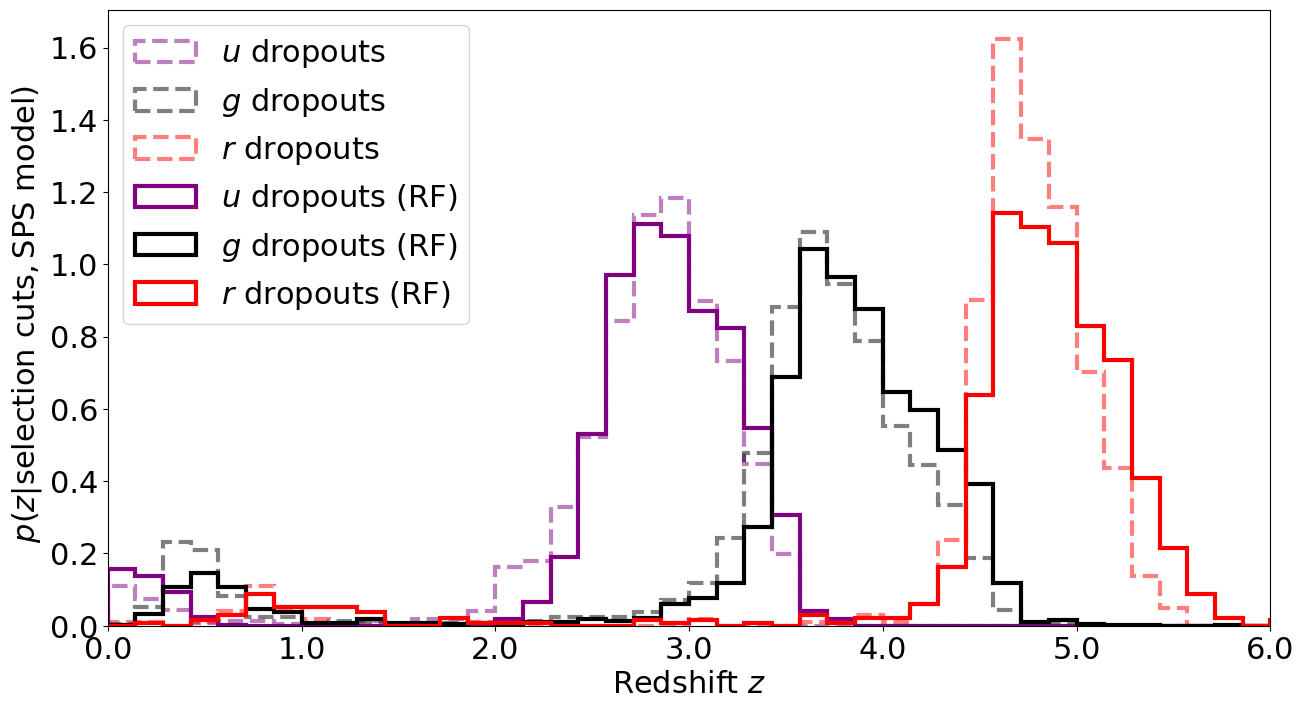

In [10]:
confidence=0.5

u_lbg_rf = get_selected_lbgs_rf(model_u, test_dataset_u, u_redshift_test, confidence_level=confidence)
g_lbg_rf = get_selected_lbgs_rf(model_g, test_dataset_g, g_redshift_test, confidence_level=confidence)
r_lbg_rf = get_selected_lbgs_rf(model_r, test_dataset_r, r_redshift_test, confidence_level=confidence)

u_lbg_trad = nzs[0]
g_lbg_trad = nzs[1]
r_lbg_trad = nzs[2]

u_lbg_trad_true = get_true_lbgs(u_lbg_trad, zl=2.5, zh=3.5)
g_lbg_trad_true = get_true_lbgs(g_lbg_trad, zl=3.5, zh=4.5)
r_lbg_trad_true = get_true_lbgs(r_lbg_trad, zl=4.5, zh=5.5)

u_lbg_true = get_true_lbgs(u_redshift_test, zl=2.5, zh=3.5)
g_lbg_true = get_true_lbgs(g_redshift_test, zl=3.5, zh=4.5)
r_lbg_true = get_true_lbgs(r_redshift_test, zl=4.5, zh=5.5)

u_eff_rf = get_efficency(model_u, test_dataset_u, u_labels_test, u_lbg_true, confidence) 
g_eff_rf = get_efficency(model_g, test_dataset_g, g_labels_test, g_lbg_true, confidence) 
r_eff_rf = get_efficency(model_r, test_dataset_r, r_labels_test, r_lbg_true, confidence) 

u_eff = (len(u_lbg_trad_true)/len(u_lbg_true))*100
g_eff = (len(g_lbg_trad_true)/len(g_lbg_true))*100
r_eff = (len(r_lbg_trad_true)/len(r_lbg_true))*100

u_pur_rf = get_purity(model_u, test_dataset_u, u_labels_test, confidence) 
g_pur_rf = get_purity(model_g, test_dataset_g, g_labels_test, confidence) 
r_pur_rf = get_purity(model_r, test_dataset_r, r_labels_test, confidence) 

u_pur = (len(u_lbg_trad_true)/len(u_lbg_trad))*100
g_pur = (len(g_lbg_trad_true)/len(g_lbg_trad))*100
r_pur = (len(r_lbg_trad_true)/len(r_lbg_trad))*100

bins = np.linspace(0, 7, 50)

print('Efficency: ', u_eff, g_eff, r_eff)
print('Efficency (RF): ', u_eff_rf, g_eff_rf, r_eff_rf)
print('Purity: ', u_pur, g_pur, r_pur)
print('Purity (RF): ', u_pur_rf, g_pur_rf, r_pur_rf)

print('Interloper Fraction: ', get_interloper_fraction(nzs[0]), get_interloper_fraction(nzs[1]), get_interloper_fraction(nzs[2]))
print('Interloper Fraction (RF): ', get_interloper_fraction(u_lbg_rf), get_interloper_fraction(g_lbg_rf), get_interloper_fraction(r_lbg_rf))

f, ax = plt.subplots(1, 1, figsize=(15, 8))


u_nz_trad = ax.hist(nzs[0], bins=bins, density=True, histtype='step', ls='--', lw=3, color='purple', alpha=0.5, label='$u$ dropouts')
g_nz_trad = ax.hist(nzs[1], bins=bins, density=True, histtype='step', ls='--', lw=3, color='black', alpha=0.5, label='$g$ dropouts')
r_nz_trad = ax.hist(nzs[2], bins=bins, density=True, histtype='step', ls='--', lw=3, color='red', alpha=0.5, label='$r$ dropouts')

u_nz = ax.hist(u_lbg_rf, bins=bins, density=True, histtype='step', ls='-', lw=3, color='purple', label='$u$ dropouts (RF)')
g_nz = ax.hist(g_lbg_rf, bins=bins, density=True, histtype='step', ls='-', lw=3, color='black', label='$g$ dropouts (RF)')
r_nz = ax.hist(r_lbg_rf, bins=bins, density=True, histtype='step', ls='-', lw=3, color='red', label='$r$ dropouts (RF)')

fs=22

ax.set_xlabel('Redshift $z$', fontsize=fs)
ax.set_xlim(0, 6)
ax.set_ylabel(' $p(z|\mathrm{selection \  cuts, SPS \ model})$', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(fontsize=fs)

In [11]:
print('Loading XSL data ...')
xsl_colours = stellar.get_xsl_LSST_colours()
xsl_labels = np.zeros(xsl_colours.shape[0])
xsl_redshifts = np.zeros(xsl_colours.shape[0])

star_dataset = create_dataset(xsl_colours, xsl_labels)
predicted_labels = make_prediction_at_confidence(model_u, star_dataset, confidence)
n_stars_incorrectly_classified_as_galaxies = len(np.where(predicted_labels > 0.0)[0])
n_stars = len(xsl_labels)

print("Fraction of Stars Incorrectly Classified as Galaxies (%): ", (n_stars_incorrectly_classified_as_galaxies/n_stars)*100)

Loading XSL data ...
1/1 [==============================] - 0s 229ms/step
Fraction of Stars Incorrectly Classified as Galaxies (%):  50.60658578856152


Text(0.5, 0, '$g - r$')

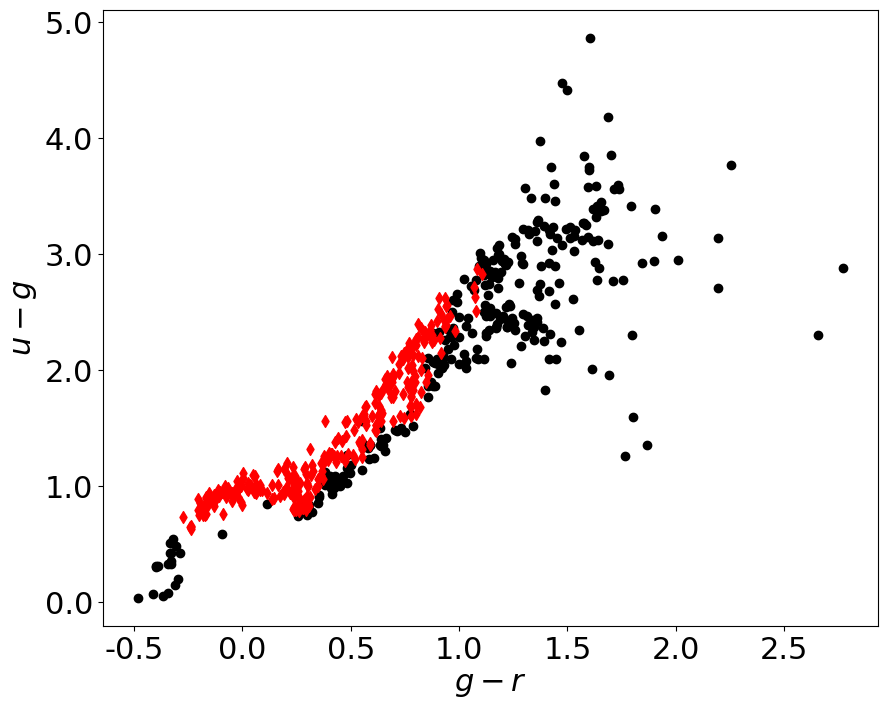

In [12]:
#stellar.plot_xsl_colour_diagram()

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

umg = xsl_colours[:, 0]
gmr = xsl_colours[:, 1]

umg_incorrect = umg[np.where(predicted_labels > 0.0)[0]]
gmr_incorrect = gmr[np.where(predicted_labels > 0.0)[0]]

umg_correct = umg[np.where(predicted_labels < 1.0)[0]]
gmr_correct = gmr[np.where(predicted_labels < 1.0)[0]]
plt.scatter(gmr_correct, umg_correct, color='k')
plt.scatter(gmr_incorrect, umg_incorrect, color='r', marker='d')

plt.ylabel("$u - g$", fontsize=fs)
plt.xlabel("$g - r$", fontsize=fs)

In [13]:
def join_noisy_data_with_stars(u_labels, g_labels, r_labels, u_redshift, g_redshift, r_redshift, u_colours, g_colours, r_colours, star_colours, star_labels, star_redshifts):

    train_star_colours = star_colours
    train_star_labels = star_labels
    train_star_redshifts = star_redshifts

    total_colours_u = np.vstack((u_colours, train_star_colours))
    total_colours_g = np.vstack((g_colours, train_star_colours))
    total_colours_r = np.vstack((r_colours, train_star_colours))

    total_labels_u = np.concatenate((u_labels, train_star_labels))
    total_labels_g = np.concatenate((g_labels, train_star_labels))
    total_labels_r = np.concatenate((r_labels, train_star_labels))

    total_redshift_u = np.concatenate((u_redshift, train_star_redshifts))
    total_redshift_g = np.concatenate((g_redshift, train_star_redshifts))
    total_redshift_r = np.concatenate((r_redshift, train_star_redshifts))

    return  total_labels_u, total_labels_g, total_labels_r, total_redshift_u, total_redshift_g, total_redshift_r, total_colours_u, total_colours_g, total_colours_r


star_train_size = int(n_stars*0.8)

train_total_labels_u, train_total_labels_g, train_total_labels_r, train_total_redshift_u, train_total_redshift_g, train_total_redshift_r, train_total_colours_u, train_total_colours_g, train_total_colours_r = join_noisy_data_with_stars(u_labels_train, g_labels_train, r_labels_train,
                                                                                                                                                                                      u_redshift_train, g_redshift_train, r_redshift_train, 
                                                                                                                                                                                      u_colours_train, g_colours_train, r_colours_train,
                                                                                                                                                                                      xsl_colours[:star_train_size, :], 
                                                                                                                                                                                      xsl_labels[:star_train_size], 
                                                                                                                                                                                      xsl_redshifts[:star_train_size])

test_total_labels_u, test_total_labels_g, test_total_labels_r, test_total_redshift_u, test_total_redshift_g, test_total_redshift_r, test_total_colours_u, test_total_colours_g, test_total_colours_r = join_noisy_data_with_stars(u_labels_test, g_labels_test, r_labels_test,
                                                                                                                                                                                      u_redshift_test, g_redshift_test, r_redshift_test, 
                                                                                                                                                                                      u_colours_test, g_colours_test, r_colours_test,
                                                                                                                                                                                      xsl_colours[star_train_size:, :], 
                                                                                                                                                                                      xsl_labels[star_train_size:], 
                                                                                                                                                                                      xsl_redshifts[star_train_size:])

model_u_stars = train_model(train_total_colours_u, train_total_labels_u, nstars=star_train_size)
model_g_stars = train_model(train_total_colours_g, train_total_labels_g, nstars=star_train_size)
model_r_stars = train_model(train_total_colours_r, train_total_labels_r, nstars=star_train_size)


Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpopiwnqaw as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'umg': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'gmr': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'rmi': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'imz': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>}
Label: Tensor("data_4:0", shape=(None,), dtype=float64)
Weights: Tensor("data_5:0", shape=(None,), dtype=float64)
Normalized tensor features:
 {'umg': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'gmr': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'rmi': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'imz': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0'

Training dataset read in 0:00:00.149197. Found 43435 examples.
Training model...
Model trained in 0:00:45.035592
Compiling model...
Model compiled.


Use 10 thread(s) for training
Use /var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/tmpi0_oivfc as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'umg': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'gmr': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'rmi': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'imz': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>}
Label: Tensor("data_4:0", shape=(None,), dtype=float64)
Weights: Tensor("data_5:0", shape=(None,), dtype=float64)
Normalized tensor features:
 {'umg': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'gmr': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'rmi': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_2:0' shape=(None,) dtype=float32>), 'imz': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_3:0'

Training dataset read in 0:00:00.139854. Found 37215 examples.
Training model...
Model trained in 0:00:17.901424
Compiling model...


Model compiled.


In [14]:
evaluate_model(model_u_stars, test_total_colours_u, test_total_labels_u)
evaluate_model(model_g_stars, test_total_colours_g, test_total_labels_g)
evaluate_model(model_r_stars, test_total_colours_r, test_total_labels_r)

25/25 [==============================] - 8s 309ms/step - loss: 0.0000e+00 - accuracy: 0.9577
loss: 0.0000
accuracy: 0.9577


45/45 [==============================] - 20s 432ms/step - loss: 0.0000e+00 - accuracy: 0.9573
loss: 0.0000
accuracy: 0.9573


39/39 [==============================] - 5s 132ms/step - loss: 0.0000e+00 - accuracy: 0.9866
loss: 0.0000
accuracy: 0.9866


0.9865775108337402

In [15]:
test_stars_dataset_u = create_dataset(test_total_colours_u, test_total_labels_u)
test_stars_dataset_g = create_dataset(test_total_colours_g, test_total_labels_g)
test_stars_dataset_r = create_dataset(test_total_colours_r, test_total_labels_r)

25/25 [==============================] - 8s 318ms/step
tf.Tensor(
[[21437   307]
 [  722  1868]], shape=(2, 2), dtype=int32)
45/45 [==============================] - 19s 423ms/step
tf.Tensor(
[[40069   783]
 [ 1112  2463]], shape=(2, 2), dtype=int32)
39/39 [==============================] - 5s 129ms/step
tf.Tensor(
[[36850   161]
 [  351   783]], shape=(2, 2), dtype=int32)
25/25 [==============================] - 7s 293ms/step
tf.Tensor(
[[21437   307]
 [  722  1868]], shape=(2, 2), dtype=int32)
45/45 [==============================] - 19s 415ms/step
tf.Tensor(
[[40069   783]
 [ 1112  2463]], shape=(2, 2), dtype=int32)
39/39 [==============================] - 5s 136ms/step
tf.Tensor(
[[36850   161]
 [  351   783]], shape=(2, 2), dtype=int32)
Efficency:  55.4054054054054 68.78321678321679 52.733686067019406
Efficency (RF):  72.12355212355213 68.8951048951049 69.04761904761905
Purity:  81.25707814269536 68.45768374164811 84.58274398868458
Purity (RF):  85.88505747126437 75.87800369685766

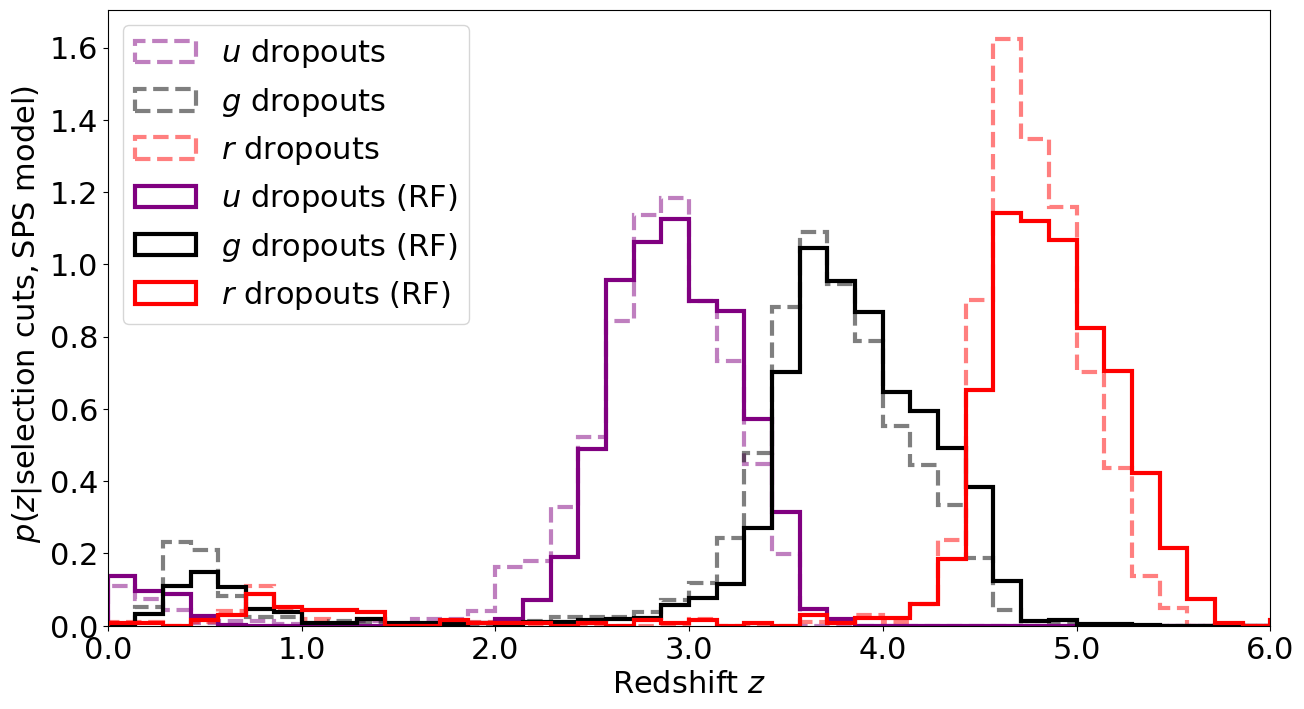

In [16]:
confidence=0.5

u_lbg_rf = get_selected_lbgs_rf(model_u_stars, test_stars_dataset_u, test_total_redshift_u, confidence_level=confidence)
g_lbg_rf = get_selected_lbgs_rf(model_g_stars, test_stars_dataset_g, test_total_redshift_g, confidence_level=confidence)
r_lbg_rf = get_selected_lbgs_rf(model_r_stars, test_stars_dataset_r, test_total_redshift_r, confidence_level=confidence)

u_lbg_trad = nzs[0]
g_lbg_trad = nzs[1]
r_lbg_trad = nzs[2]

u_lbg_trad_true = get_true_lbgs(u_lbg_trad, zl=2.5, zh=3.5)
g_lbg_trad_true = get_true_lbgs(g_lbg_trad, zl=3.5, zh=4.5)
r_lbg_trad_true = get_true_lbgs(r_lbg_trad, zl=4.5, zh=5.5)

u_lbg_true = get_true_lbgs(test_total_redshift_u, zl=2.5, zh=3.5)
g_lbg_true = get_true_lbgs(test_total_redshift_g, zl=3.5, zh=4.5)
r_lbg_true = get_true_lbgs(test_total_redshift_r, zl=4.5, zh=5.5)

u_eff_rf = get_efficency(model_u_stars, test_stars_dataset_u, test_total_labels_u, u_lbg_true, confidence) 
g_eff_rf = get_efficency(model_g_stars, test_stars_dataset_g, test_total_labels_g, g_lbg_true, confidence) 
r_eff_rf = get_efficency(model_r_stars, test_stars_dataset_r, test_total_labels_r, r_lbg_true, confidence) 

u_eff = (len(u_lbg_trad_true)/len(u_lbg_true))*100
g_eff = (len(g_lbg_trad_true)/len(g_lbg_true))*100
r_eff = (len(r_lbg_trad_true)/len(r_lbg_true))*100

u_pur_rf = get_purity(model_u_stars, test_stars_dataset_u, test_total_labels_u, confidence) 
g_pur_rf = get_purity(model_g_stars, test_stars_dataset_g, test_total_labels_g, confidence) 
r_pur_rf = get_purity(model_r_stars, test_stars_dataset_r, test_total_labels_r, confidence) 

u_pur = (len(u_lbg_trad_true)/len(u_lbg_trad))*100
g_pur = (len(g_lbg_trad_true)/len(g_lbg_trad))*100
r_pur = (len(r_lbg_trad_true)/len(r_lbg_trad))*100

bins = np.linspace(0, 7, 50)

print('Efficency: ', u_eff, g_eff, r_eff)
print('Efficency (RF): ', u_eff_rf, g_eff_rf, r_eff_rf)
print('Purity: ', u_pur, g_pur, r_pur)
print('Purity (RF): ', u_pur_rf, g_pur_rf, r_pur_rf)

print('Interloper Fraction: ', get_interloper_fraction(nzs[0]), get_interloper_fraction(nzs[1]), get_interloper_fraction(nzs[2]))
print('Interloper Fraction (RF): ', get_interloper_fraction(u_lbg_rf), get_interloper_fraction(g_lbg_rf), get_interloper_fraction(r_lbg_rf))

f, ax = plt.subplots(1, 1, figsize=(15, 8))


u_nz_trad = ax.hist(nzs[0], bins=bins, density=True, histtype='step', ls='--', lw=3, color='purple', alpha=0.5, label='$u$ dropouts')
g_nz_trad = ax.hist(nzs[1], bins=bins, density=True, histtype='step', ls='--', lw=3, color='black', alpha=0.5, label='$g$ dropouts')
r_nz_trad = ax.hist(nzs[2], bins=bins, density=True, histtype='step', ls='--', lw=3, color='red', alpha=0.5, label='$r$ dropouts')

u_nz = ax.hist(u_lbg_rf, bins=bins, density=True, histtype='step', ls='-', lw=3, color='purple', label='$u$ dropouts (RF)')
g_nz = ax.hist(g_lbg_rf, bins=bins, density=True, histtype='step', ls='-', lw=3, color='black', label='$g$ dropouts (RF)')
r_nz = ax.hist(r_lbg_rf, bins=bins, density=True, histtype='step', ls='-', lw=3, color='red', label='$r$ dropouts (RF)')

fs=22

ax.set_xlabel('Redshift $z$', fontsize=fs)
ax.set_xlim(0, 6)
ax.set_ylabel(' $p(z|\mathrm{selection \  cuts, SPS \ model})$', fontsize=fs)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(fontsize=fs)

1/1 [==============================] - 0s 327ms/step
Fraction of Stars Incorrectly Classified as Galaxies (%):  1.0398613518197575


Text(0.5, 0, '$g - r$')

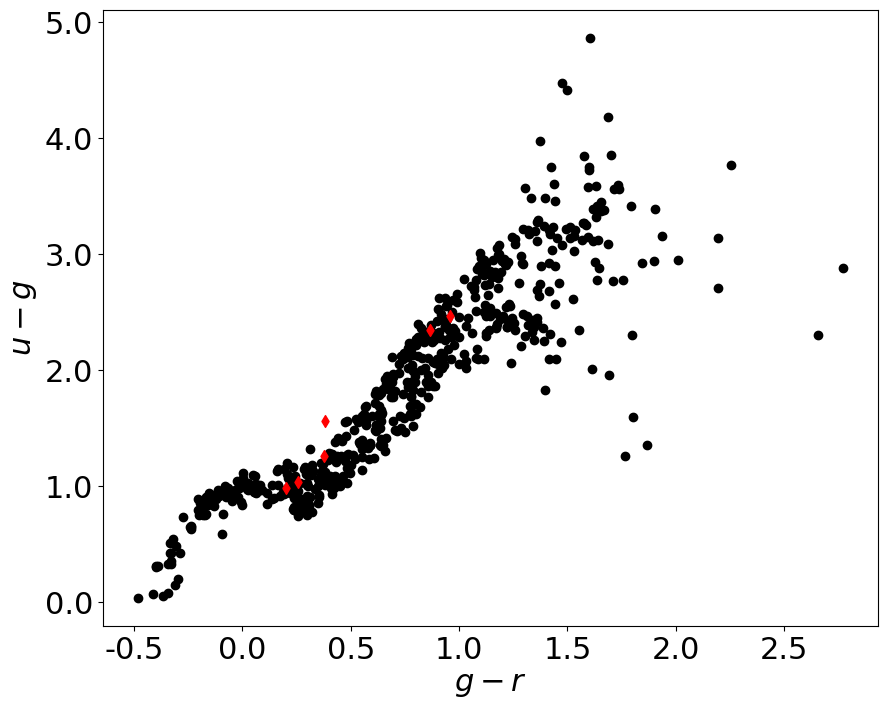

In [17]:
star_dataset = create_dataset(xsl_colours, xsl_labels)
predicted_labels = make_prediction_at_confidence(model_u_stars, star_dataset, confidence)
n_stars_incorrectly_classified_as_galaxies = len(np.where(predicted_labels > 0.0)[0])
n_stars = len(xsl_labels)

print("Fraction of Stars Incorrectly Classified as Galaxies (%): ", (n_stars_incorrectly_classified_as_galaxies/n_stars)*100)

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax.tick_params(axis='x', labelsize=fs)
ax.tick_params(axis='y', labelsize=fs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

umg = xsl_colours[:, 0]
gmr = xsl_colours[:, 1]

umg_incorrect = umg[np.where(predicted_labels > 0.0)[0]]
gmr_incorrect = gmr[np.where(predicted_labels > 0.0)[0]]

umg_correct = umg[np.where(predicted_labels < 1.0)[0]]
gmr_correct = gmr[np.where(predicted_labels < 1.0)[0]]
plt.scatter(gmr_correct, umg_correct, color='k')
plt.scatter(gmr_incorrect, umg_incorrect, color='r', marker='d')

plt.ylabel("$u - g$", fontsize=fs)
plt.xlabel("$g - r$", fontsize=fs)

In [18]:
g_lbg_trad.shape, g_lbg_true.shape

((3592,), (3575,))